In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.figsize'] = [5, 5]
sns.set(rc={'figure.figsize':(5, 5)})

In [134]:
data= 'dataset01_sfu_hierarchical_forecast_project.csv'
df = pd.read_csv(data,)# index_col='Unnamed: 0')


In [5]:
!pip list


Package            Version            
------------------ -------------------
attrs              19.3.0             
backcall           0.1.0              
bleach             3.1.0              
bokeh              1.4.0              
cassandra-driver   3.18.0             
certifi            2019.11.28         
Click              7.0                
cloudpickle        1.3.0              
convertdate        2.1.3              
cycler             0.10.0             
Cython             0.29.15            
cytoolz            0.10.1             
dask               2.11.0             
decorator          4.4.1              
defusedxml         0.6.0              
distributed        2.11.0             
entrypoints        0.3                
ephem              3.7.7.0            
fbprophet          0.6                
featuretools       0.13.3             
fsspec             0.6.2              
HeapDict           1.0.1              
holidays           0.10.1             
imageio            2.6.1 

In [3]:
df

,Unnamed: 0,year,month,week,province,city,store,category,department,class,vendor,size,totalQuantity,totalSales
0,0,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size26,1.0,424.971081
1,1,2012,1,1,province2,city15,store33,category1,department1,class7,vendor2,size29,-1.0,-424.971081
2,3,2012,1,1,province1,city18,store51,category1,department1,class7,vendor2,size29,1.0,424.971081
3,4,2012,1,1,province3,city31,store62,category1,department1,class7,vendor2,size29,1.0,424.971081
4,5,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size33,1.0,424.971081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348925,2639097,2018,1,1,province2,city12,store31,category2,department12,class41,vendor11,size1,2.0,85.708453
2348926,2639098,2018,1,1,province1,city39,store43,category2,department12,class41,vendor11,size1,2.0,85.708453
2348927,2639099,2018,1,1,province1,city23,store56,category2,department12,class41,vendor11,size1,1.0,42.854227
2348928,2639100,2018,1,1,province1,city35,store45,category2,department12,class41,vendor84,size1,1.0,103.564381


In [4]:
df['time'] = df['year'].astype(str) + " " + df['week'].astype(str) + " 0"
df['time'] = pd.to_datetime(df['time'], format="%Y %W %w")
df = df.set_index(df['time'])
df = df.drop(columns='time')
df

,Unnamed: 0,year,month,week,province,city,store,category,department,class,vendor,size,totalQuantity,totalSales
time,,,,,,,,,,,,,,
2012-01-08,0,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size26,1.0,424.971081
2012-01-08,1,2012,1,1,province2,city15,store33,category1,department1,class7,vendor2,size29,-1.0,-424.971081
2012-01-08,3,2012,1,1,province1,city18,store51,category1,department1,class7,vendor2,size29,1.0,424.971081
2012-01-08,4,2012,1,1,province3,city31,store62,category1,department1,class7,vendor2,size29,1.0,424.971081
2012-01-08,5,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size33,1.0,424.971081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,2639097,2018,1,1,province2,city12,store31,category2,department12,class41,vendor11,size1,2.0,85.708453
2018-01-07,2639098,2018,1,1,province1,city39,store43,category2,department12,class41,vendor11,size1,2.0,85.708453
2018-01-07,2639099,2018,1,1,province1,city23,store56,category2,department12,class41,vendor11,size1,1.0,42.854227


In [5]:
# Necessary package for determining whether a day falls on a Canadian Federal Holiday.
# !~/anaconda3/bin/conda install workalendar

In [6]:
# !~/anaconda3/bin/conda list
# !which python

In [5]:
# Create label for whether transaction occurred on a holiday week.

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from workalendar.america import Canada

minyear = df.index.min().year
maxyear = df.index.max().year

dr = pd.date_range(start=str(minyear), end=str(maxyear))

# USFederal Holidays as per calendar
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
holidays_week = holidays.year.astype(str) + " " + holidays.week.astype(str) + " 0"
holidays_week = pd.to_datetime(holidays_week, format="%Y %W %w")
# print(holidays_week)

df['Holiday'] = df.index.isin(holidays_week) # Create boolean field for whether this transaction occured on a holiday week

# print(df.count(), df['Holiday'].sum())
df

# Canadian federal holidays as per `workalender` package
canada = Canada()

# Retrieve holidays for relevant years
can_holiday = []
[can_holiday.extend(canada.holidays(y)) for y in range(minyear, maxyear) ]

can_holiday = np.array(can_holiday)
can_holiday = pd.DataFrame(can_holiday, columns=['Date', 'event'])
# print(can_holiday)

# Convert holidays to Datetime object
can_holiday['Date'] = pd.to_datetime(can_holiday['Date'].astype(str), format="%Y-%M-%d")

# Represent Datetime in (year, week, end of week) format
can_holidays_week = can_holiday.Date.dt.year.astype(str) + " " + can_holiday.Date.dt.week.astype(str) + " 0"
can_holidays_week = pd.to_datetime(can_holidays_week, format="%Y %W %w")

df['Holiday'] = df.index.isin(can_holidays_week) | df['Holiday'] # Create boolean field for whether this transaction occured on a holiday week

# print(df.count(), df['Holiday'].sum())
df

,Unnamed: 0,year,month,week,province,city,store,category,department,class,vendor,size,totalQuantity,totalSales,Holiday
time,,,,,,,,,,,,,,,
2012-01-08,0,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size26,1.0,424.971081,True
2012-01-08,1,2012,1,1,province2,city15,store33,category1,department1,class7,vendor2,size29,-1.0,-424.971081,True
2012-01-08,3,2012,1,1,province1,city18,store51,category1,department1,class7,vendor2,size29,1.0,424.971081,True
2012-01-08,4,2012,1,1,province3,city31,store62,category1,department1,class7,vendor2,size29,1.0,424.971081,True
2012-01-08,5,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size33,1.0,424.971081,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,2639097,2018,1,1,province2,city12,store31,category2,department12,class41,vendor11,size1,2.0,85.708453,True
2018-01-07,2639098,2018,1,1,province1,city39,store43,category2,department12,class41,vendor11,size1,2.0,85.708453,True
2018-01-07,2639099,2018,1,1,province1,city23,store56,category2,department12,class41,vendor11,size1,1.0,42.854227,True


In [7]:
df.to_csv('dataset-02.csv')

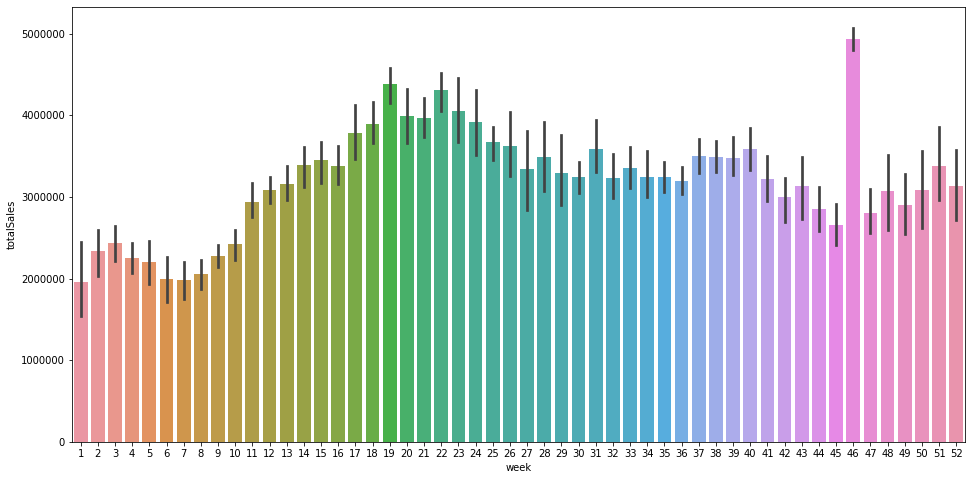

In [7]:
yw = df.groupby(['year','week']).agg({'totalSales':'sum'})
yw = yw.reset_index()


# plt.bar(x='week', height='totalSales', data=yw);
# sns.barplot(x='week', y='totalSales', data = yw);
sns.barplot(x='week', y='totalSales', data = yw);

In [94]:
df1 = df[['year','month','province', 'department', 'totalSales']]
df1 = df1.groupby(['year','month', 'province', 'department']).agg({'totalSales': 'sum'})
df1 = df1.reset_index()
df1 = df1[(df1['province'] == 'province1') & (df1['department'] == 'department1')]
print(df1)

      year  month   province   department     totalSales
0     2012      1  province1  department1  367848.182322
27    2012      2  province1  department1  290414.165970
54    2012      3  province1  department1  424692.314095
80    2012      4  province1  department1  595865.308679
106   2012      5  province1  department1  480301.244209
...    ...    ...        ...          ...            ...
1750  2017      9  province1  department1  410200.443120
1777  2017     10  province1  department1  422912.720910
1805  2017     11  province1  department1  458903.343187
1835  2017     12  province1  department1  465680.810554
1865  2018      1  province1  department1   39200.403852

[73 rows x 5 columns]


In [122]:
train_df = df1[df1['year'] <= 2015]
validation_df = df1[df1['year'] > 2015]
my_list = train_df['totalSales'].tolist()
print(my_list)


[367848.1823220047, 290414.1659704093, 424692.31409508083, 595865.3086788495, 480301.2442089894, 433861.9043927952, 418618.2274349423, 393428.87013493775, 615026.6476123508, 795955.4783142587, 639938.7380659989, 720754.7385602577, 412281.51578921435, 300925.80779904313, 463436.4632810839, 815853.7670985321, 568023.0604787408, 489878.3067783305, 385327.9214021857, 349297.8732366694, 432016.6013937088, 741293.6266090783, 588580.6615398641, 620487.9188315496, 509943.0128093869, 366583.911212437, 488595.8226224427, 828606.7564041157, 648145.251043708, 542989.7639874142, 570132.059819083, 404748.0284408806, 481245.25139814196, 726917.6763169589, 546106.2661960461, 432063.7410430127, 375423.9525072953, 287438.58274371235, 447874.66511414736, 725114.3704599822, 587730.9336493174, 478526.36498901364, 485732.0175035614, 421381.68223977677, 611935.1437025954, 675448.5359201148, 548829.0094855712, 440482.2395951605]


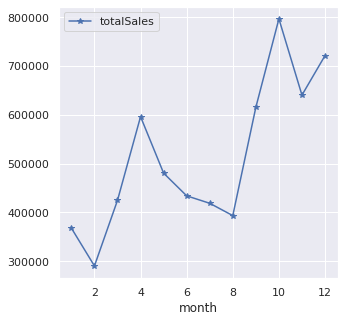

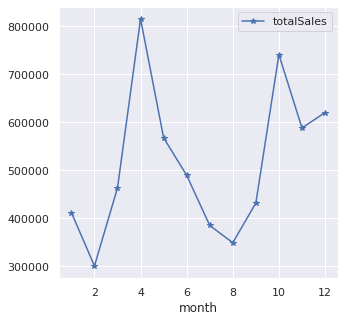

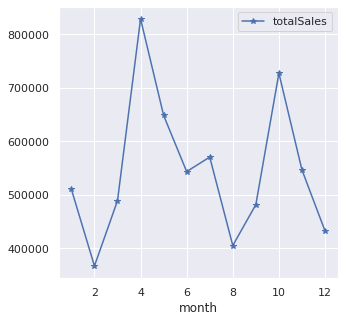

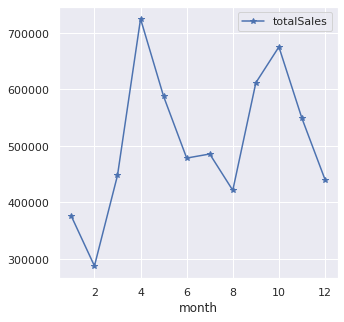

In [110]:
year = [2012, 2013, 2014, 2015]
for i in year:
    train_df[train_df['year'] == i].plot(x='month', y='totalSales', marker='*')

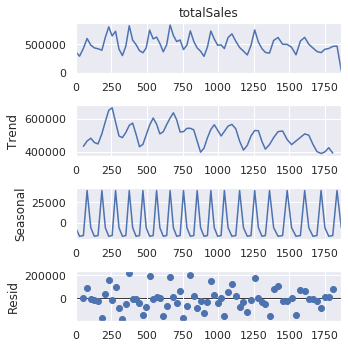

In [131]:
decomposition = sm.tsa.seasonal_decompose(df1['totalSales'], period = 4)
fig = decomposition.plot()
plt.show()



In [124]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(train_df['totalSales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.136248
p-value                         0.000843
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
